# Chapter 3: Classification

## MNIST

The MNIST dataset is a set of 70,000 small images of digits handwritten by students and US Census Bureau employees. Each image is labeled with the digit it represents. 

Scikit-Learn has many helper functions to download popular datasets. MNIST is one of them:

In [1]:
import os
import pandas as pd 
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:

    1. A DESCR key describing the dataset.
    2. A `data` key containing an array with one row per instance and one column per feature.
    3. A `target` key containing an array with the labels.

In [2]:
mnist['data'].head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


We can see that the `data` value is a Pandas DataFrame of shape (70000, 784). Each instance represents an image, meaning that the resolution of each image is about 28x28 pixels (the image is flattened into a 784x1 array). Each feature represents one pixel's intensity, from 0 (white) to 255 (black). We can view a digit like so:

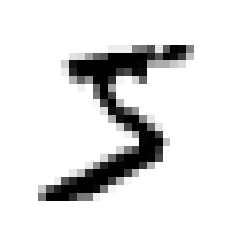

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = np.array(X.iloc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

This image looks like a 5. Indeed, if we check the label, we can confirm that it is a 5:

In [5]:
y.iloc[0]

'5'

Note that the label is a string. Since ML algorithms will expect numbers, we will cast `y` to integers.

In [6]:
y = y.astype(np.uint8)

First we need to split the dataset into test and training sets. This is already done though. The first 60,000 images are part of the training set and the last 10,000 are the test set.

In [7]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

Further, the datasets are already shuffled, meaning that all cross-validation folds will be similar.

## Training a Binary Classifier

To start, we will simplify the problem and only try to identify one digit--the number 5. This '5-detector' will be an example of a *binary classifier*, captable of distinguishing between just two classes, 5 and not-5. In the following, we will create target vectors for this classification task, i.e. 'Is this digit a 5?'.

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

We will start with a *Stochastic Gradient Descent* (SGD) classifier, using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently, because SGD deals with training instances independently, one at a time.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train.values, y_train_5.values)

sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor! There are many performance measures available.

### Measuring Accuracy Using Cross-Validation

We will use the `cross_val_score()` function to evaluate the `SGDClassifier` model, using K-fold cross-validation with three folds. Recall that K-fold cross-validation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds:

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

While we may be awestruck at the accuracy achieved with cross-validation, think about what would happen with a classifier that just classified every single image into the 'not-5' class. If 10% of the images are actually 5's and we classify everything as 'not-5', the model will still have about a 90% accuracy!

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e. when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*. The general idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, we need to have a set of predictions so that they can be compared to the actual targets. We could make predictions on the test set, but let's keep it untouched for now (remember that you want to use the test set only at the very end of the project, once we have a classifier that we are ready to launch). Instead we use the `cross_val_predict()` function:

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `corss_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set ('clean' meaning that the prediction is made by a model that never saw the data during training).

Now we're reading to get the confusion matrix using the `confusion_matrix()` function:

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*. The first row of the matrix considers non-5 images (the *negative class*): 53892 of them were correctly classified as non-5's (these are called *true negatives*), while the remaining 687 were wrongly classified as 5s (*false positives*). The second row considers the images of 5s (the *positive class*): 1891 were wrongly classified as non-5s (*false negatives*), while the remaining 3530 were correctly classified as 5s (*true positives*). A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its diagonal:

In [13]:
y_train_perfect_predictions = y_train_5  # pretend we got a perfect prediction set
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives us a lot of information, but sometimes we would prefer a more concise metrix. An interesting one to look at is the accuracy of the positive predictions; this is called the *precision* of the classifier.

$
\text{precision} = \frac{TP}{TP+FP}
$

$TP$ is the number of true positives, and $FP$ is the number of false positives.

Precision is typically used along with another metrix named *recall*, or *sensitivity* or *true positive rate*: this is the ratio of positive instances that are correctly detected by the classifier:

$
\text{recall} = \frac{TP}{TP+FN}
$

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


Suddenly, the 5-detector model does not look as good as it did when we only used cross-validation to evaluate how good of a model it was. The model is only correct 84% of the time when it classifies an image as a 5. On the other hand, it only detects 65% of the 5s.

It is often convenient to combine precision and recall into a single metric called the $F_{1}$ *score*, in particular if you need a simple way to compare two classifiers. The $F_{1}$ score is the *harmonic mean* of precision and recall. Where as the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_{1}$ score if both the precision and recall are high.

$
F_{1} = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}=2\frac{\text{precision x recall}}{\text{precision + recall}} = \frac{TP}{TP+\frac{FN+FP}{2}}
$

To compute the $F_{1}$ score, call the `f1_score()` function:

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_{1}$ score favors classifiers that have similar precision and recall. This is NOT always what we want: in some contexts we care mostly about precision, and sometimes we care about recall more.

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only the safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product.

On the other hand, suppose we train a classifier to detect shoplifters in surveillance images: it is probably fine if the classifier has only 30% precision as long as it has 99% recall. We would prefer to catch all of the shoplifters and get a few false positives than to miss a lot of shoplifters but have no false positives.

Unfortunately, we cannot have it both ways: increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

### Precision/Recall Trade-off

The `SGDClassifier` makes its classifiction decisions based on a score computed by a *decision function*. If the score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

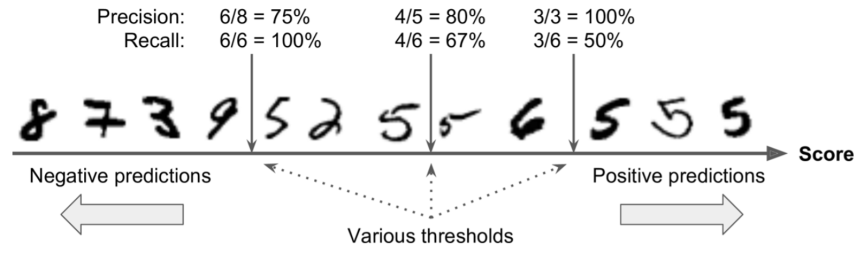

Scikit-Learn does not let you set the threshold direction, but we are still able to access the decision scores that it uses to make predictions. Instead of calling the classifier's `predict()` method, you can call its `deicion_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [17]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method. If we raise the threshold, we see something different:

In [18]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall, i.e. the true positive has become a false negative.

How do we decide what threshold to use? First, we can use the `cross_val_prodict()` function to get the scores of all instances in the training set, but this time specify that we want to return decision scores instead of predictions:

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

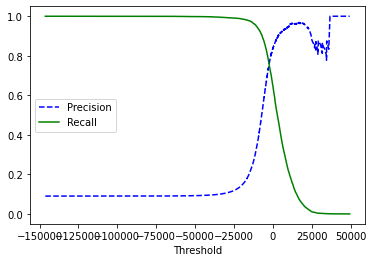

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(['Precision', 'Recall'])
    plt.xlabel('Threshold')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

Text(0, 0.5, 'Precision')

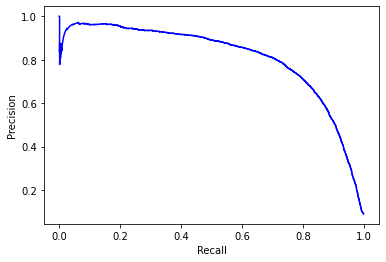

In [21]:
plt.clf()
plt.plot(recalls, precisions, 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')

We can see that precision starts to fall sharply around 80% recall. It's likely we'd want to select a precision/recall trade-off just before that drop. The choice really depends on the project needs.

Suppose we aim for 90% precision. We look up the first plot and find that we need to use a threshold of about 8,000. To be more precise, we can search for the lowest threshold that gives us at least 90% precision using `np.argmax()`, which will give us the first index of the maximum value, which in this case means the first True value):

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] 
threshold_90_precision

3370.0194991439557

Now to make predictions, instead of calling the classifiers's `predict()` method, we run this code:

In [23]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

And we can check the predictions' precision and recall:

In [24]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

We now have a 90% precision classifier! It is fairly easy to create a classifier with virtually any precision we want: we just need to set a high enough threshold. Remember though, a high-precision classifier is not very useful if its recall is too low!

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is similar to the precision/recall curve, but plots the *true positive rate* (another name for recall) against the *false positive rate* (FPR). The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the *true negative rate* (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus 1 - *specificity*.

To plot the ROC curve, we must first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:

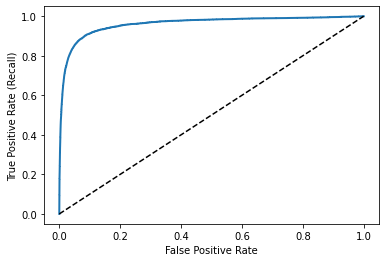

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')  # dashed diagonal
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR) curve, one may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are a few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvements (the curve could be closer to the top-right corner).

Let's now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`. First we need to get scores for each instance in the training set. But due to the way it works, the `RandomForestClassifier` does not have a `decision_function()` method. Instead, it has a `predict_proba()` method. Scikit-Learn classifiers generall have one or the other, or both. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., a 70% change that the image represents a 5):

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba', n_jobs=3)

The `roc_curve()` function expects labels and scores, but instead of scores we can give it class probabilities. We will use the positive class's probability as the score:

Shape of proba array:  (60000, 2)


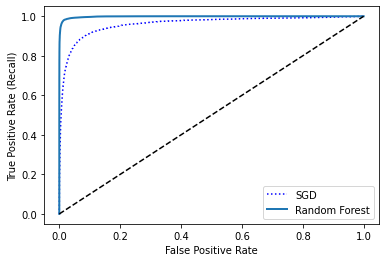

ROC_AUC forest score:  0.9983436731328145


In [29]:
print('Shape of proba array: ', y_probas_forest.shape)
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

print('ROC_AUC forest score: ', roc_auc_score(y_train_5, y_scores_forest))

In [30]:
y_train_forest = pd.Series([True if x[1] > x[0] else False for x in y_probas_forest])

print('precision forest score: ', precision_score(y_train_5, y_train_forest))
print('recall forest score: ', recall_score(y_train_5, y_train_forest))

precision forest score:  0.9905083315756169
recall forest score:  0.8662608374838591


We find a precision score of 99.0% and a recall score of 86.6% for the `RandomForestClassifier`!

## Multiclass Classification

Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multi-class classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, etc.). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called *one-versus-the-rest* (OvR) strategy (also called *one-versus-all*).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the *one-versus-one* (OvO) strategy. If we have N classes, we'll have N*(N-1)/2 classifiers. When you want to classify an image, you have to run the image through all 45 classifiers, for MNIST, and see which class wins the most duels. The advantage of this method is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms scale poorly with the size of the training set (e.g. Support Vector Machine classifiers). OvO is preferred in this instance because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets.

Scikit-Learn detects when you try to use a binary classification system for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. For example, with a Support Vector Machine classifier:

In [31]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train.values, y_train.values)
svc_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, Scikit-Learn used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image we passed in, and selected the class that won the most duels.

If we call the `decision_function()` method, we can see that it returns 10 scores per instance (instead of just 1). There is one score per class (the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores):

In [32]:
some_digit_scores = svc_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


We can see that the highest score is indeed the one corresponding to class 5:

In [33]:
index_of_max_score = np.argmax(some_digit_scores)
print(svc_clf.classes_[index_of_max_score])

5


If we want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, we can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an `SVC`:

In [34]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.values, y_train.values)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [35]:
len(ovr_clf.estimators_)

10

We also can train an `SGDClassifier`:

In [36]:
sgd_clf = OneVsRestClassifier(SGDClassifier(random_state=42))
sgd_clf.fit(X_train.values, y_train.values)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The `decision_function()` method now returns one value per class. Let's look at the score that the SGD classifier assigned to each class:

In [37]:
sgd_clf.decision_function([some_digit])

array([[-13781.33922923, -24334.62190222, -11148.68966068,
         -3664.79262749, -20719.95525531,   2164.22030239,
        -31446.3628772 , -15088.01473606, -12954.44836362,
        -10802.51962293]])

We see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of ~2164. It looks like the model may be unsure about the 3-class, since its score is much less negative than everything else. Now of course we want to evaluate the classifier. We will, as usual, use cross-validation.

In [38]:
cross_val_score(sgd_clf, X_train.values, y_train.values, cv=3, scoring='accuracy', n_jobs=3)

array([0.8556 , 0.86845, 0.88235])

It gets over 85% on all test folds. If we used a random classifier though, we would get 10%, so this is not a BAD score, but we can do better. Simply by scaling the inputs using `StandardScaler` increases the accuracy:

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train.values, cv=3, scoring='accuracy', n_jobs=3)

array([0.90015, 0.89525, 0.9055 ])

And now we have over 89.5% on all folds!

### Error Analysis

To improve this model we now move on to analyzing the types of errors it makes. First, we generate the confusion matrix. We need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function:

In [40]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5583,    0,   23,    7,    9,   46,   34,    7,  213,    1],
       [   0, 6403,   37,   26,    4,   45,    4,    8,  202,   13],
       [  28,   26, 5252,   99,   72,   27,   64,   38,  342,   10],
       [  22,   17,  117, 5257,    2,  215,   25,   39,  365,   72],
       [  12,   14,   49,   12, 5217,   12,   31,   24,  301,  170],
       [  27,   16,   34,  175,   55, 4485,   73,   16,  478,   62],
       [  30,   16,   45,    3,   45,   98, 5550,    6,  124,    1],
       [  19,    9,   53,   33,   51,   13,    3, 5708,  169,  207],
       [  17,   63,   46,   93,    3,  130,   24,   11, 5419,   45],
       [  24,   18,   30,   67,  116,   39,    1,  181,  329, 5144]])

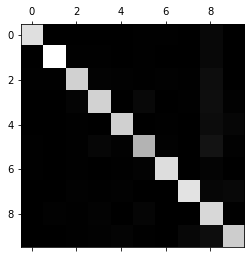

In [41]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Above we have visualized the confusion matrix as an image. Most images are on the main diagonal, i.e. they were classified correctly. It looks like the (5, 5) square is slightly darker. This could mean that there are fewer images of 5s in the dataset or that hte classifier does not perform as well on 5s as on other digits. In order to verify that both are the case, we'll deivide each value in the confusion matrix by the number of images in the corresponding class so that we can compare error rates instead of absolute numbers of errors. That would make abundant classes look unfairly bad:

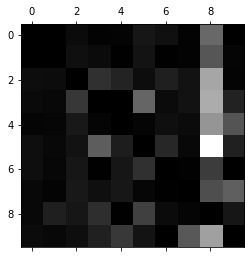

In [42]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)  # fill diagonal with zeros to keep only the errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

We can clearly see what kinds of error the classifier is making now. The column for class 8 is pretty bright, which tells us that a lot of numbers get misidentified as 8s. But, the row for 8 is not as bad, telling us that actual 8s in general get properly classified. We can also see that a fair amount of 3s and 5s are getting misclassified.

Analyzing the confusion matrix often gives us insights into ways we can improve our classifiers. Looking at this plot, it seems that our efforts should be spent on reducing the false 8s. We could try gathering more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or, we could engineer new features that would help the classifier--for example, writing an algorithm to count the number of closed loops. Or, we could preprocess the images to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights on what the classifier is doing and why it is failing, but it is more difficult and time-consuming. For example, let's plot examples of 3s and 5s:

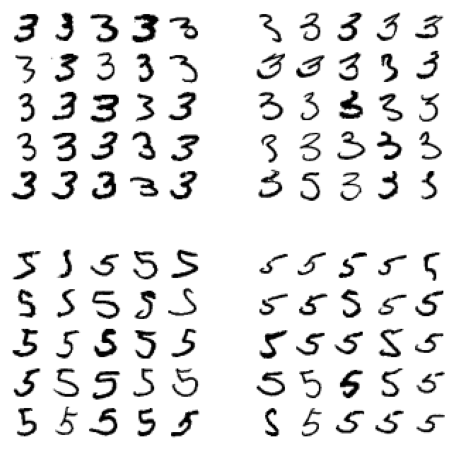

In [43]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show digits classified as 3s, and the two 5x5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us, and it's hard to understand why the classifier made the mistakes it did. The reason is that we used a simple `SGDClassifier`, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

## Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

To achieve exceptional accuracy I'm going to try using the `KNeighborsClassifier` model. A grid search on the `weights` and `n_neighbors` hyperparameters will be used to find the best settings. Further, we'll test this model with the scaled training set first.

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# X_train_scaled, y_train.values
k_neighbors_clf = KNeighborsClassifier()

param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20]}
]

grid_search = GridSearchCV(k_neighbors_clf, param_grid, cv=3, 
                           scoring='accuracy', return_train_score=True, 
                           n_jobs=5)

grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=5,
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, scoring='accuracy')

In [45]:
print(grid_search.best_params_)
print(grid_search.cv_results_['mean_test_score'])

{'n_neighbors': 4, 'weights': 'distance'}
[0.96755    0.96755    0.96055    0.96755    0.96818333 0.96933333
 0.96663333 0.97035    0.96741667 0.9686     0.96286667 0.96501667
 0.96025    0.9614     0.95675    0.95888333]


In [46]:
from sklearn.metrics import accuracy_score

final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test.values)

print(accuracy_score(y_test, final_predictions))

0.9714


2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally train your best model on this expanded training set and measure its accuracy o nthe test set.

In [92]:
from scipy.ndimage import shift

def shift_MNIST_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.flatten()
    # output is ndarray

X_train_with_shifted = X_train.to_numpy()
y_train_with_shifted  = y_train.to_numpy()

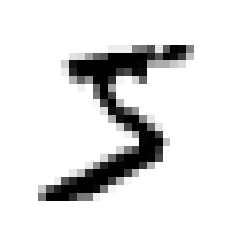

300000
300000


In [93]:
some_digit = np.array(X_train_with_shifted[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()


# create a shifted copy for each number in the training set
shifted_images = []
shifted_labels = []
for image, label in zip(X_train.to_numpy(), y_train.to_numpy()):
    # left, right, up, down
    for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1)):
        shifted_image = shift_MNIST_image(image, dx, dy)
        shifted_images.append(shifted_image)
        shifted_labels.append(label)
        
X_train_with_shifted = np.append(X_train_with_shifted, shifted_images, axis=0)
y_train_with_shifted = np.append(y_train_with_shifted, shifted_labels, axis=0)

print(len(X_train_with_shifted))
print(len(y_train_with_shifted))

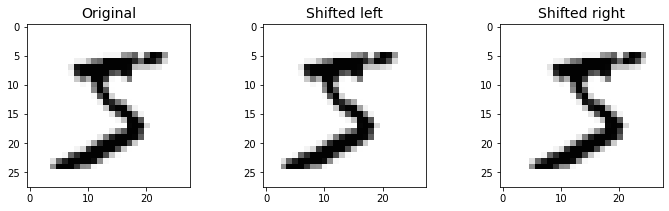

shifted left:  5
shifted right:  5


In [94]:
some_digit = np.array(X_train_with_shifted[0])
some_digit_image = some_digit.reshape(28, 28)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(some_digit_image, interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted left", fontsize=14)
plt.imshow(X_train_with_shifted[60000].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted right", fontsize=14)
plt.imshow(X_train_with_shifted[60001].reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

print('shifted left: ', y_train_with_shifted[60000])
print('shifted right: ', y_train_with_shifted[60001])

In [95]:
shuffle_idx = np.random.permutation(len(X_train_with_shifted))
X_train_with_shifted = X_train_with_shifted[shuffle_idx]
y_train_with_shifted = y_train_with_shifted[shuffle_idx]

final_model_shifted_imgs = grid_search.best_estimator_

final_model_shifted_imgs.fit(X_train_with_shifted, y_train_with_shifted)

final_predictions = final_model_shifted_imgs.predict(X_test.values)

print(accuracy_score(y_test, final_predictions))

0.9763
